In [5]:
import yaml

def load_config(config_path):
    with open(config_path, "r") as f:
        return yaml.safe_load(f)

config_path = "audioldm/ciap/configs/ciap_config.yaml"
config = load_config(config_path)

In [6]:
import torch
from audioldm.ciap.models.image_encoder import ImageEncoder
from audioldm.ciap.models.audio_encoder import AudioEncoder
import random

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the models
image_encoder = ImageEncoder(config["model"]["image_encoder"]).to(device)
audio_encoder = AudioEncoder(config["model"]["audio_encoder"]).to(device)

# Load the checkpoints
image_encoder_ckpt = "/Users/luffy_sama/Desktop/Workspace/IE_643/AudioLDM/ckpt/ciap_image_encoder2.pt"
audio_encoder_ckpt = "/Users/luffy_sama/Desktop/Workspace/IE_643/AudioLDM/ckpt/ciap_audio_encoder2.pt"

image_encoder.load_state_dict(torch.load(image_encoder_ckpt, map_location=device))
audio_encoder.load_state_dict(torch.load(audio_encoder_ckpt, map_location=device))

print("Checkpoints loaded successfully!")

Checkpoints loaded successfully!


In [7]:
import os
import torch
from audioldm import build_model, save_wave
from audioldm.ciap.models.image_encoder import ImageEncoder
from audioldm.ciap.models.audio_encoder import AudioEncoder
from audioldm.ciap.datasets.paired_image_audio_dataset import PairedImageAudioDataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

# Set CIAP models to evaluation mode
image_encoder.eval()
audio_encoder.eval()

# Load LDM model
ldm_ckpt_path = "./ckpt/audioldm-s-full.ckpt"
audioldm = build_model(ckpt_path=ldm_ckpt_path)

Load AudioLDM: %s audioldm-s-full
DiffusionWrapper has 185.04 M params.


/Users/luffy_sama/Desktop/Workspace/IE_643/.venv/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Sample 1:
Requested latent_t_size: 124
Adjusted latent_t_size:  128
Latent frequency size kept fixed: 16


Sampling t: 100%|██████████| 1000/1000 [07:11<00:00,  2.32it/s]


Mel shape: torch.Size([1, 1, 1024, 64])
Waveform shape: (1, 1, 80000)
Waveform duration (sec): 5.0
Save audio to ./output/00022_0.wav
Generated audio saved to ./output/00022_0.wav


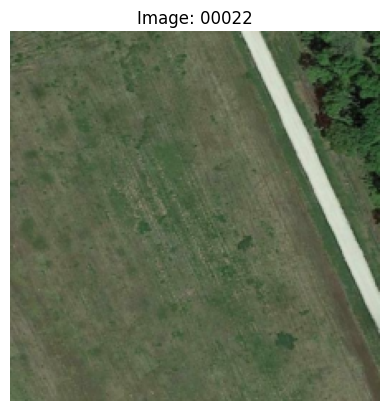

--------------------------------------------------


In [9]:
import os
import math
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from audioldm.ciap.models.ciap_cond import CIAPCondStage

# --- Dataset setup ---
dataset_path = config["dataset"]["val"]["path"]
image_ext = config["dataset"]["val"].get("image_extension", ".png")
audio_ext = config["dataset"]["val"].get("audio_extension", ".wav")

dataset = PairedImageAudioDataset(dataset_path, image_ext=image_ext, audio_ext=audio_ext)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

# --- Output directory ---
output_dir = "./output"
os.makedirs(output_dir, exist_ok=True)

# --- Helper function ---
def ceil_to_multiple(x, m):
    return int(math.ceil(x / m) * m)

# --- Parameters ---
max_samples = 1
desired_seconds = 5
sample_rate = 16000
target_waveform_length = desired_seconds * sample_rate

UNET_FACTOR = 32  # AudioLDM UNet downsampling factor

# --- Inference loop ---
with torch.no_grad():
    for idx, (image, audio, image_path) in enumerate(dataloader):
        if idx >= max_samples:
            break

        image = image.to(device)

        cond = CIAPCondStage(image_encoder, audio_encoder, embed_dim=512, device='cpu')

        # get image embedding and unconditional condition
        img_emb = cond.encode(image)                      # already on device and normalized
        uncond = cond.get_unconditional_condition(batch_size=img_emb.shape[0])

        print(f"\nSample {idx + 1}:")

        # Step 2: Compute latent shape compatible with UNet
        latent_t_size = int(312 * (target_waveform_length / 199712))
        latent_t_size_adj = ceil_to_multiple(latent_t_size, UNET_FACTOR)

        # ✅ Keep frequency dimension fixed (64) — to match HiFi-GAN vocoder
        latent_f_size_adj = audioldm.latent_f_size

        print(f"Requested latent_t_size: {latent_t_size}")
        print(f"Adjusted latent_t_size:  {latent_t_size_adj}")
        print(f"Latent frequency size kept fixed: {latent_f_size_adj}")

        shape = (1, audioldm.channels, latent_t_size_adj, latent_f_size_adj)

        # pass both to sampler if supported
        waveform_latent = audioldm.sample(
            cond=img_emb,
            batch_size=1,    # tune 1.2-4.0
        )

        # Step 4: Decode to mel and waveform
        mel = audioldm.decode_first_stage(waveform_latent)
        waveform = audioldm.mel_spectrogram_to_waveform(mel)

        # Step 5: Crop to desired duration
        if waveform.shape[-1] > target_waveform_length:
            waveform = waveform[..., :target_waveform_length]

        print("Mel shape:", mel.shape)
        print("Waveform shape:", waveform.shape)
        print("Waveform duration (sec):", waveform.shape[-1] / sample_rate)

        # Step 6: Save generated audio
        image_name = os.path.basename(image_path[0]).split(".")[0]
        save_wave(waveform, savepath=output_dir, name=image_name)
        print(f"Generated audio saved to {output_dir}/{image_name}_0.wav")

        # Step 7: Display the image
        plt.imshow(image[0].permute(1, 2, 0).cpu().numpy())
        plt.title(f"Image: {image_name}")
        plt.axis("off")
        plt.show()

        print("-" * 50)
